In [1]:
import torch 
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split 

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark  = False

seed = 59
set_seed(seed)

In [3]:
root_dir = 'data/weather-dataset/dataset'
img_paths = []
labels =  []
classes = {
    label_idx: class_namw for label_idx, class_namw in enumerate(os.listdir(root_dir))
}

In [4]:
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(img_paths, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle)

In [6]:
class WeatherDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]


In [7]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img


In [8]:
train_dataset = WeatherDataset(X_train, y_train, transform=transform)
val_dataset = WeatherDataset(X_val, y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform=transform)


In [45]:
train_dataset_length = len(train_dataset)
print("Shape of train_dataset:", train_dataset_length)

Shape of train_dataset: 4802


In [18]:
len(train_dataset)


4802

In [9]:
train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)


In [56]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out


In [57]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 =  self.create_layer(residual_block, 64, 64, n_blocks_lst[0],1)
        self.conv3 =  self.create_layer(residual_block, 64, 128, n_blocks_lst[1],2)
        self.conv4 =  self.create_layer(residual_block, 128, 256, n_blocks_lst[2],2)
        self.conv5 =  self.create_layer(residual_block, 256, 512, n_blocks_lst[3],2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            blocks.append(residual_block(out_channels, out_channels, stride))

        block_sequential = nn.Sequential(*blocks)

        return block_sequential
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.max_pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [58]:
from torchsummary import summary
n_classes = len(list(classes.keys()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(ResidualBlock, [2, 2, 2, 2], n_classes).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [59]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [60]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            print(inputs.shape)
            print(labels.shape)
            optimizer.zero_grad()
            outputs = model(inputs)
            print(outputs.shape) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses


In [61]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [62]:
train_losses , val_losses = fit(model, train_loader, val_loader, criterion ,optimizer ,device ,epochs)

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 11])
torch.Size([32, 3, 224, 224])
torch.Size([32])
t

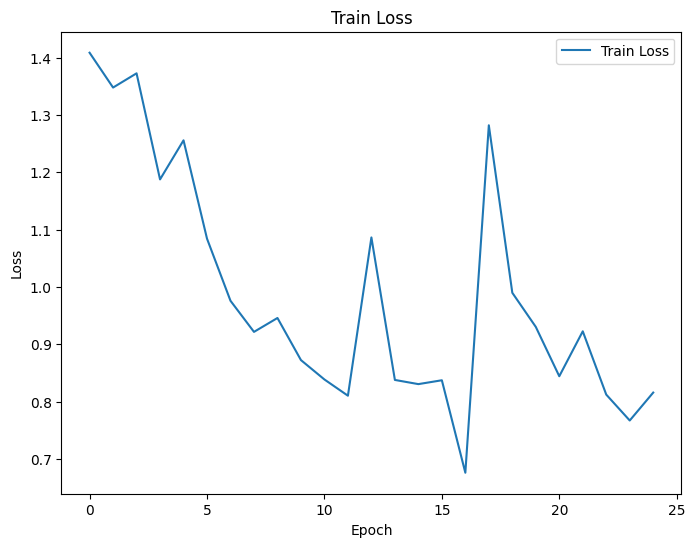

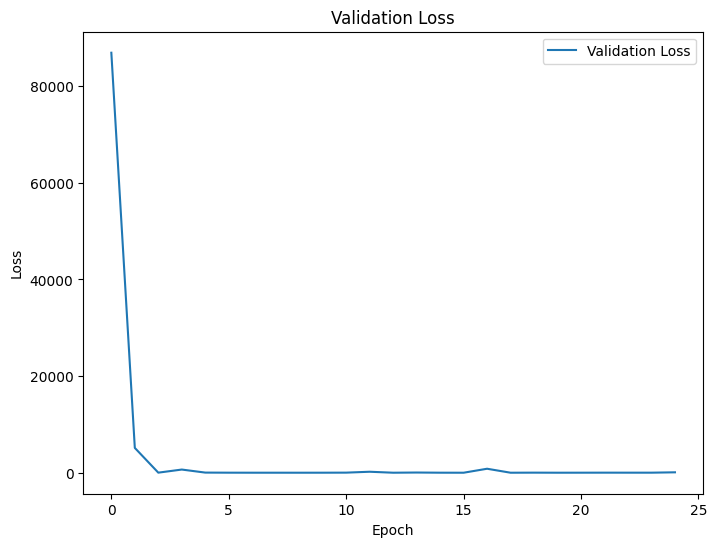

In [64]:
import matplotlib.pyplot as plt

# Chart 1: Train Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

# Chart 2: Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [ ]:
eval = evaluate(model, test_loader, criterion, device)